-----   Word found: QUERY   -----
-----   Word found: QUERN   -----
-----   Word found: EUCRE   -----
-----   Word found: LUCRE   -----


In [20]:
for word in all_words :
    print(word)

In [46]:
alphabet = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n" \
           , "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

is_valid_word = lambda word : True if np.sum([(letter in alphabet) for letter in word.lower()]) == 5 else False

five_word_set = [w.lower() for w in english_words_set if len(w) == 5 and is_valid_word(w)]
print(f"{len(five_word_set)} five letter words found")

3194 five letter words found


In [92]:

word_scores = {}

def eval_letter_score_noconstraint(target_letter, num_word_set=five_word_set, den_word_set=five_word_set) :
    num, den = 0, len(den_word_set)
    for word in num_word_set :
        if target_letter not in word : continue
        num += 1
    return num/den

def get_ordered_word_scores() :
    ordered_words = [(key,val) for (key,val) in word_scores.items()]
    ordered_words.sort(key=lambda w : w[1], reverse=True)
    return ordered_words

def populate_word_scores_v1() :
    word_scores.clear()
    letter_scores = {}
    for letter in alphabet : 
        letter_scores[letter] = eval_letter_score(letter)
    eval_word_score = lambda word : np.sum([letter_scores[letter] for letter in word])
    best_word, best_word_score = "", 0
    for word in five_word_set :
        word_scores[word] = eval_word_score(word)

populate_word_scores_v1()
get_ordered_word_scores()[:5]


[('eerie', 1.9574201628052599),
 ('reese', 1.948340638697558),
 ('aerie', 1.9467752035065748),
 ('erase', 1.9376956793988729),
 ('eater', 1.9329993738259237)]

In [109]:
def count_instances_of_letter_in_word(word, letter) :
    return np.sum([l==letter for l in word])   

def eval_letter_score_constraining_repeated_letters(target_letter, previous_letters=[], num_word_set=five_word_set, den_word_set=five_word_set) :
    if target_letter not in previous_letters :
        return eval_letter_score_noconstraint(target_letter, num_word_set=num_word_set, den_word_set=den_word_set)
    previous_letter_count = len([True for l in previous_letters if l == target_letter])
    num = len([w for w in num_word_set if count_instances_of_letter_in_word(w, target_letter) > previous_letter_count])
    den = len(den_word_set)
    return num / den

def populate_word_scores_v2() :
    word_scores.clear()
    for word_idx, word in enumerate(five_word_set) :
        sys.stdout.write(f"\rProcessing word {word_idx+1}/{len(five_word_set)}")
        word_score = 0
        for l_idx in range(len(word)) :
            word_score += eval_letter_score_constraining_repeated_letters(word[l_idx], [l for l in word[:l_idx]])
        word_scores[word] = word_score
    sys.stdout.write("\n")
            
populate_word_scores_v2()
get_ordered_word_scores()[:5]


Processing word 3194/3194


[('arose', 1.7861615529117094),
 ('orate', 1.7814652473387602),
 ('erato', 1.78146524733876),
 ('aires', 1.7745773324984346),
 ('raise', 1.7745773324984346)]

In [256]:
possible_guesses = []

def reset_possible_guesses() :
    global possible_guesses
    possible_guesses = sorted([w for w in five_word_set])

def guess(true_word, guess_word) :
    global possible_guesses
    correct_spaces, incorrect_spaces, correct_letters, absent_letters = [], [], [], []
    remove_incs_from_word, reduced_guess_letters = [], []
    for l_idx, (tl, gl) in enumerate(zip(true_word, guess_word)) :
        if tl != gl :
            reduced_guess_letters.append(gl)
            incorrect_spaces.append((l_idx, gl))
            continue
        correct_spaces.append((l_idx, gl))
        remove_incs_from_word.append(l_idx)
    reduced_true_word = true_word
    for l_idx in remove_incs_from_word[::-1] :
        reduced_true_word = reduced_true_word[:l_idx] + reduced_true_word[1+l_idx:]
    for guess_letter in reduced_guess_letters :
        guess_letter_idx = reduced_true_word.find(guess_letter)
        if guess_letter_idx >= 0 :
            correct_letters.append(guess_letter)
            reduced_true_word = reduced_true_word[:guess_letter_idx] + reduced_true_word[1+guess_letter_idx:]
        else :
            absent_letters.append(guess_letter)
    absent_letters = set(absent_letters)
    if guess_word in possible_guesses :
        del possible_guesses[possible_guesses.index(guess_word)]
    return correct_spaces, incorrect_spaces, correct_letters, absent_letters

In [257]:
true_word  = "query"

possible_words = five_word_set

assert len(true_word ) == 5
assert len(guess_word) == 5

correct_spaces, incorrect_spaces, correct_letters, absent_letters = guess(true_word, guess_word)

print(f"GUESS      {guess_word}")
print(f"GREEN      {correct_spaces}")
print(f"NOT GREEN  {incorrect_spaces}")
print(f"YELLOW     {correct_letters}")
print(f"BLACK      {absent_letters}")


GUESS      arhat
GREEN      []
NOT GREEN  [(0, 'a'), (1, 'r'), (2, 'h'), (3, 'a'), (4, 't')]
YELLOW     ['r']
BLACK      {'t', 'a', 'h'}


In [284]:
possible_answers = []

def populate_word_scores_v3() :
    word_scores.clear()
    for word_idx, word in enumerate(possible_guesses) :
        #sys.stdout.write(f"\rCalculating score for guess word {word_idx+1}/{len(five_word_set)}")
        word_score = 0
        for l_idx in range(len(word)) :
            word_score += eval_letter_score_constraining_repeated_letters(word[l_idx], 
                                                                          [l for l in word[:l_idx]],
                                                                          num_word_set=possible_answers,
                                                                          den_word_set=possible_answers)
        word_scores[word] = word_score
    #sys.stdout.write("\n")
    
def reset_possible_answers() :
    global possible_answers
    possible_answers = sorted([w for w in five_word_set])
    
def update_possible_answers(correct_spaces=[], incorrect_spaces=[], correct_letters=[], absent_letters=[]) :
    tmp_possible_answers = []
    global possible_answers
    for possible_answer in possible_answers :
        is_possible = True
        #
        #print(f"Correct spaces: {correct_spaces}")
        for (idx, letter) in correct_spaces :
            if possible_answer[idx] != letter :
                #if turn_count>1 and is_possible : print(f"{possible_answer.upper()} because it doesn't have an {letter.upper()} at index {idx}")
                is_possible = False
        if not is_possible : continue
        #
        #print(f"Incorrect spaces: {incorrect_spaces}")
        for (idx, letter) in incorrect_spaces :
            if possible_answer[idx] == letter :
                #if turn_count>1 and is_possible : print(f"{possible_answer.upper()} because it has an {letter.upper()} at index {idx}")
                is_possible = False
        if not is_possible : continue
        #
        remove_idcs_from_word = sorted([idx for (idx,letter) in correct_spaces])
        reduced_possible_answer = possible_answer
        for l_idx in remove_idcs_from_word[::-1] :
            reduced_possible_answer = reduced_possible_answer[:l_idx] + reduced_possible_answer[1+l_idx:]
        #if len(correct_spaces) > 0 :
        #    print(correct_spaces)
        #    print(f"{possible_answer} reduced to {reduced_possible_answer}")
        #
        #print(f"Correct letters: {correct_letters}")
        for correct_letter in correct_letters : 
            l_idx = reduced_possible_answer.find(correct_letter)
            if l_idx < 0 :
                #if turn_count>1 and is_possible : print(f"{possible_answer.upper()} ({reduced_possible_answer}) because it doesn't have an {correct_letter.upper()}")
                is_possible = False
            else :
                reduced_possible_answer = reduced_possible_answer[:l_idx] + reduced_possible_answer[1+l_idx:]
        if not is_possible : continue
        #
        #print(f"Incorrect letters: {correct_letters}")
        for absent_letter in absent_letters :
            if absent_letter in reduced_possible_answer :
                #if turn_count>1 and is_possible : print(f"{possible_answer.upper()} ({reduced_possible_answer}) because it has an {absent_letter.upper()}")
                is_possible = False
        if not is_possible : continue
        #
        tmp_possible_answers.append(possible_answer)
    possible_answers = tmp_possible_answers


In [287]:
def update_constraints(new_correct_spaces, new_incorrect_spaces, new_correct_letters, new_absent_letters) :
    global correct_spaces, incorrect_spaces, correct_letters, absent_letters
    tmp_correct_spaces, tmp_incorrect_spaces, tmp_correct_letters, tmp_absent_letters = [], [], [], []
            
    tmp_incorrect_spaces = [item for item in incorrect_spaces]
    for (idx, letter) in new_incorrect_spaces :
        if (idx, letter) in incorrect_spaces : continue
        tmp_incorrect_spaces.append((idx, letter))
        
    tmp_correct_spaces   = [item for item in correct_spaces  ]
    tmp_correct_letters  = [item for item in correct_letters ]
    
    for (idx, letter) in new_correct_spaces :
        if (idx, letter) in correct_spaces : continue
        tmp_correct_spaces.append((idx, letter))
        
    tmp_correct_letters  = []
    for letter in set(new_correct_letters + correct_letters) :
        num_times_in_new_answer  = len([True for l in new_correct_letters if l==letter]) + len([True for (i,l) in new_correct_spaces if l==letter])
        num_times_in_old_answer  = len([True for l in     correct_letters if l==letter]) + len([True for (i,l) in     correct_spaces if l==letter])
        num_times_in_corr_spaces = len([True for (i,l) in tmp_correct_spaces if l==letter])
        num_times_expected       = np.max([num_times_in_new_answer, num_times_in_old_answer]) - num_times_in_corr_spaces
        for i in range(num_times_expected) : tmp_correct_letters.append(letter)
            
    tmp_absent_letters   = [item for item in absent_letters  ]
    for letter in new_absent_letters :
        if letter not in tmp_absent_letters : tmp_absent_letters.append(letter)
                
    correct_spaces, incorrect_spaces, correct_letters, absent_letters = tmp_correct_spaces, tmp_incorrect_spaces, tmp_correct_letters, tmp_absent_letters
            

In [431]:
correct_spaces, incorrect_spaces, correct_letters, absent_letters = [], [], [], []
turn_count = 0

def play_game(game_label="", true_word=None, verbose=True) :
    global correct_spaces, incorrect_spaces, correct_letters, absent_letters, turn_count
    
    if type(true_word) != str :
        true_word = np.random.choice(five_word_set, size=(1,))[0].lower()
    else :
        true_word = true_word.lower()
        assert len(true_word) == 5
        
    if verbose :
        print_line = f"---  BEGIN GAME {game_label}: WORD IS '{true_word.upper()}' ---"
        print("-"*len(print_line))
        print(print_line)
        print("-"*len(print_line))
    
    start_time = time.time()

    reset_possible_guesses()
    reset_possible_answers()

    guess_word = ""
    turn_count = 0
    correct_spaces, incorrect_spaces, correct_letters, absent_letters = [], [], [], []
    while guess_word != true_word :
        turn_count += 1
        if verbose : print(f"\nTurn {turn_count}")
        if turn_count == 1 :
            guess_word = "arose"
        elif len(possible_answers) == 1 :
            guess_word = possible_answers[0]
        else :
            populate_word_scores_v3()
            guess_word = get_ordered_word_scores()[0][0]
        if verbose : print(f"Guessing word {guess_word.upper()}")
        new_correct_spaces, new_incorrect_spaces, new_correct_letters, new_absent_letters = guess(true_word, guess_word)
        if guess_word == true_word :
            end_time = time.time()
            if verbose : print(f"SUCCESS IN {turn_count} TURNS and {end_time-start_time:.2f}s\n")
        else : 
            update_constraints(new_correct_spaces, new_incorrect_spaces, new_correct_letters, new_absent_letters)
            update_possible_answers(correct_spaces, incorrect_spaces, correct_letters, absent_letters)
            if verbose : print(f"{len(possible_answers)} possible answers remain")
        #
        
    return turn_count, end_time-start_time
    

In [432]:

play_game(true_word="razor")


-------------------------------------
---  BEGIN GAME : WORD IS 'RAZOR' ---
-------------------------------------

Turn 1
Guessing word AROSE
43 possible answers remain

Turn 2
Guessing word ARMCO
19 possible answers remain

Turn 3
Guessing word BOARD
3 possible answers remain

Turn 4
Guessing word ARGOT
2 possible answers remain

Turn 5
Guessing word KAROL
1 possible answers remain

Turn 6
Guessing word RAZOR
SUCCESS IN 6 TURNS and 0.86s



(6, 0.8630177974700928)

In [413]:
num_games = 2000
win_indices_and_times = []

for game_idx in range(num_games) :
    sys.stdout.write(f"\rRunning toy {1+game_idx} / {num_games}")
    win_indices_and_times.append(play_game(1+game_idx, verbose=False))
    
win_indices_and_times = np.array(win_indices_and_times)

win_indices = win_indices_and_times[:,0]
game_times  = win_indices_and_times[:,1]


Running toy 2000 / 2000

In [426]:

num_turns_mean = np.mean(win_indices_and_times[:,0])
num_turns_std  = np.std (win_indices_and_times[:,0])
num_turns_SEM  = num_turns_std / np.sqrt(len(win_indices_and_times))
    
print(f"Mean number of turns is {num_turns_mean:.2f} +/- {num_turns_SEM:.2f}")
print(f"Std  number of turns is {num_turns_std:.2f}")


Mean number of turns is 3.92 +/- 0.02
Std  number of turns is 0.94


In [414]:
def histo_line(bins, hvals) :
    x = [bins[0]]
    for b in bins[1:-1] :
        x.append(b)
        x.append(b)
    x.append(bins[-1])
    y = []
    for v in hvals :
        y.append(v)
        y.append(v)
    return np.array(x), np.array(y)

def safe_divide(num, den) :
    return np.array([n/d if np.fabs(d)>0 else np.nan for n,d in zip(num, den)])


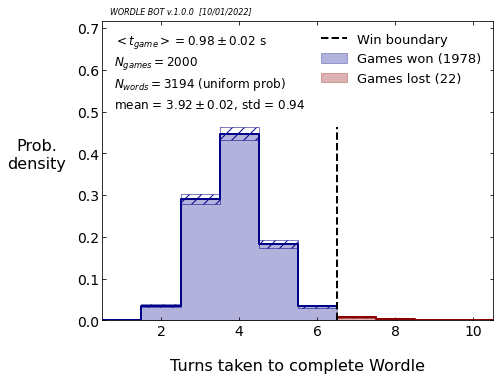

In [428]:

fig = plt.figure(figsize=(7, 5.5))
ax  = fig.add_subplot(1, 1, 1)

bin_min, bin_max = 1, int(np.max([6, np.max(win_indices)])) + 1
bins          = np.linspace(bin_min-0.5, bin_max+0.5, 2+bin_max-bin_min)
overflow_bins = np.linspace(6.5, np.max([bin_max,7])+0.5, 2+np.max([bin_max,7])-7)

h_absvals, _ = np.histogram(win_indices, bins=bins)
h_relvals    = h_absvals / len(win_indices)
h_abserrs    = np.sqrt(h_absvals)
h_relerrs    = h_abserrs / len(win_indices)

hval_max = np.max(h_relvals+h_relerrs)

h_split_idx = list(bins).index(6.5)

x_blue, y_blue    = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx])
x_blue, y_blue_hi = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx] + h_relerrs[:h_split_idx])
x_blue, y_blue_lo = histo_line(bins[:h_split_idx+1], h_relvals[:h_split_idx] - h_relerrs[:h_split_idx])

ax.fill_between(x_blue, 0*y_blue , y_blue   , color="darkblue", alpha=0.3, label=f"Games won ({np.sum(win_indices<7)})")
ax.plot(x_blue, y_blue, color="darkblue", lw=2)
ax.fill_between(x_blue, y_blue_lo, y_blue_hi, lw=0.5, color="none", ec="darkblue", hatch='//')

x_red , y_red     = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:])
x_red , y_red_hi  = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:] + h_relerrs[h_split_idx:])
x_red , y_red_lo  = histo_line(bins[h_split_idx:], h_relvals[h_split_idx:] - h_relerrs[h_split_idx:])

ax.fill_between(x_red, 0*y_red , y_red   , color="darkred", alpha=0.3, label=f"Games lost ({np.sum(win_indices>6)})")
ax.plot(x_red, y_red, color="darkred", lw=2)
ax.fill_between(x_red, y_red_lo, y_red_hi, lw=0.5, color="none", ec="darkred", hatch='//')

ax.plot([6.5, 6.5], [0, hval_max], lw=2, ls="--", c="k", label="Win boundary")

ax.set_xlabel("Turns taken to complete Wordle", rotation=0, fontsize=16, labelpad=20)
ax.set_ylabel("Prob.\ndensity", rotation=0, fontsize=16, labelpad=40)
ax.tick_params(axis="both", direction="in", top=True, right=True, labelsize=14)
ax.set_xlim([bins[0], bins[-1]])
ax.set_ylim([0, 1.55*hval_max])
ax.legend(loc="upper right", frameon=False, fontsize=13)

ax.text(0.03, 0.96, r"$<t_{game}> = "+f"{np.mean(game_times):.2f} \pm {np.std(game_times)/np.sqrt(num_games):.2f}$ s", ha="left", va="top", transform=ax.transAxes, fontsize=12)
ax.text(0.03, 0.89, r"$N_{games}"+f"={num_games}$", ha="left", va="top", transform=ax.transAxes, fontsize=12)
ax.text(0.03, 0.82, r"$N_{words}"+f"={len(five_word_set)}$ (uniform prob)", ha="left", va="top", transform=ax.transAxes, fontsize=12)
ax.text(0.03, 0.75, f"mean = ${num_turns_mean:.2f} \pm {num_turns_SEM:.2f}$, std = ${num_turns_std:.2f}$", ha="left", va="top", transform=ax.transAxes, fontsize=12)
ax.text(0.02, 1.02, "WORDLE BOT v.1.0.0  [10/01/2022]", style="italic", fontsize=8, ha="left", va="bottom", transform=ax.transAxes)

plt.savefig("Wordle_bot_v1p0p0_220110.jpg", dpi=200, bbox_inches="tight")
plt.show()
